
# IMDB Dataset of 50K Movie Reviews




In this notebook, we perform a sentiment analysis on a Kaggle dataset of movie reviews. Here is the description from Kaggle:

"IMDB dataset having 50K movie reviews for natural language processing or Text analytics. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms."

The approach we take in this notebook is to use a recurrent neural network with a long short-term memory (LSTM) cell. Step-by-step:

* Obtain the data from Kaggle.

* Preprocess the data by tokenizing words and forming a vocabulary.

* Form the LSTM neural network model.  

* Split the data into train and test set as indicated (25K each).

* Train the model using stochastic gradient descent. Due to GPU constraints, I was not able to train on the entire data set.

* Evaluate the model on the test set.

We begin with standard imports:

In [1]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
from matplotlib import pyplot as plt
import csv

## 1. Obtaining and preprocessing the data

### Obtain the data from Kaggle

The first step is to obtain the data from Kaggle. We follow the instructions on this [page](https://towardsdatascience.com/downloading-kaggle-datasets-directly-into-google-colab-c8f0f407d73a). The first step is to mount google drive:

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive



We set the Kaggle configuration directory to be where the kaggle.json token is located.

In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/gdrive/MyDrive/kaggle'

Download the movie reviews data (this requires installation of the kaggle package via `pip install kaggle`, if necessary).


In [6]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 35% 9.00M/25.7M [00:00<00:00, 18.6MB/s]
100% 25.7M/25.7M [00:00<00:00, 52.2MB/s]


Finally, copy the zip to the virtual machine and unzip it there.


In [7]:
zip_path = '/gdrive/MyDrive/kaggle/imdb-dataset-of-50k-movie-reviews.zip'
!cp '{zip_path}' .
!unzip -q 'imdb-dataset-of-50k-movie-reviews.zip'

Check the working directory to see that the necessary files are there.


In [8]:
os.listdir()

['.config',
 'IMDB Dataset.csv',
 'imdb-dataset-of-50k-movie-reviews.zip',
 'sample_data']

### Read the data

The next step is to read the data into a pandas dataframe.

In [9]:
# Read the data into a pandas dataframe
data = pd.read_csv("IMDB Dataset.csv", lineterminator='\n', converters={"review": str(), "sentiment": str()})
num_samples = len(data)
train_size = int(num_samples*0.5)
test_size = num_samples - train_size
shuffled_data = data.sample(frac=1)
train_data, test_data = shuffled_data[:25000].copy(), shuffled_data[25000:].copy()
train_data

,review,sentiment
49192,"Can I please say first of all, that I felt so ...",negative
4503,The fact that a film is on DVD doesn't guarant...,negative
14905,Do people rate this movie highly because it's ...,negative
39467,This is a great game! Okay perhaps it didn't h...,positive
33609,"As predictable as a Hallmark card, but not wit...",positive
...,...,...
11336,I saw this movie by accident yesterday at a ci...,negative
19838,This movie received a great write up in Blockb...,negative
30780,This Movie as the 1st KSA's movie should be ac...,negative
18157,I'm seldom partial to movies about smart-assed...,positive


### Tokenize

The next few steps involve producing the vocabulary. First, we define a function to remove punctuation and numbers. Unit tests can be run, if desired.



Next, we tokenize the reviews by splitting them into words, and applying preprocessing to each word.

### The vocabulary

The vocabulary encapuslates the frequencies of the tokens, and lets us move between tokens and indices.

In [10]:
from collections import Counter
import itertools
import re


class VocabFromReviews:
    """
    The Vocab takes a pd.Series of reviews, processes them into tokens by descending frequency, and creates dictionaries to move between tokens and indices
    """
    def __init__(self, reviews: pd.Series, min_freq: int = 0):
      tokenized_series = reviews.apply(
          lambda review_text : [self.preprocess_string(word) for word in review_text.split()]
      )
      tokenized_list = tokenized_series.to_list()
      tokens = list(itertools.chain.from_iterable(tokenized_list))
      counts = Counter(tokens)
      self.token_freqs = sorted(counts.items(), key=lambda x: x[1], reverse=True)
      self.idx_to_token = list(sorted(set(
          ['<unk>'] + [token for token, freq in self.token_freqs if freq >= min_freq])))
      self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def preprocess_string(self, s: str):
      """ Keep only words, and make them lower case. Remove breaks."""
      s = re.sub(r"[^\w\s]", '', s).lower()
      s = re.sub(r"\s+", '', s)
      s = re.sub(r"\d", '', s)
      if s == "br": return ""
      return s

    def __len__(self):
      return len(self.idx_to_token)

    def convert_tokenized_review_to_indices(self, single_tokenized_review : list):
      indices = []
      for token in single_tokenized_review:
          if token in self.token_to_idx and token:
              indices.append(self.token_to_idx[token])
      return indices


    def process_and_convert_review_to_tensor(self, input_reviews: pd.Series):
      """
      Take a pd.Series of reviews, tokenize, index according to the vocab dictionary, pad, and convert to a tensor
      """
      indexed_series = input_reviews.apply(
          lambda review_text :
            self.convert_tokenized_review_to_indices(
              [self.preprocess_string(word) for word in review_text.split()]
          )
      )
      max_length = indexed_series.apply(lambda l : len(l)).max()
      padded_indexed_series = indexed_series.apply(
        lambda review_indices : [0]*(max_length- len(review_indices)) + review_indices
      )
      return torch.tensor(padded_indexed_series.values.tolist())


We can now create the vocab for our tokenized reviews.

In [11]:
vocab = VocabFromReviews(train_data["review"], min_freq=5)

In [12]:
train_features = vocab.process_and_convert_review_to_tensor(train_data["review"])
print(f"size of train features = {train_features.size()}")


size of train features = torch.Size([25000, 2353])


In [13]:
# For the labels, encode positive as 1 and negative as 0
train_labels_pd = train_data["sentiment"].apply(lambda s: int(s == "positive"))
train_labels = torch.tensor(train_labels_pd.values.tolist()).unsqueeze(1).float()
print(f"size of train labels = {train_labels.size()}")


size of train labels = torch.Size([25000, 1])



## 2. Model and training

### Hidden state recurrent NN

Now I define the recurrent neural network model. The model is many-to-one since we input a tokenized string but output only a single value (positive/negative). Hence, I have a hidden recurrent neural network that outputs a single value at the end, and this value is plugged into a fully connected neural network.

In [16]:
class RNNHidden(nn.Module):
    def __init__(self, num_layers, input_dim, embedding_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first = True)

    def forward(self, text):

        #text.size() = (batch size, length of sequence)
        embedded = self.embedding(text)

        #embedded.size() = (batch_size, length of sequence)
        _, hidden = self.lstm(embedded)

        # Since this is a Many-to-One model, return only the last output
        return hidden[-1][0]

### Training set-up

The next few cells set up the training of our model by checking if there is a GPU, defining the accuracy function, and definig the training loop.

In [17]:
is_cuda = torch.cuda.is_available()

# If there is a GPU available, the device will be the GPU.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [18]:
# Binary accuracy function for evaluation
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

We arrive at the training loop for the network.

In [67]:
import tqdm


def train(model, dataloader, optimizer, criterion, num_epochs, verbose=False):

    train_loss = []
    train_acc = []
    # test_loss = []
    # test_acc = []


    for i in tqdm.tqdm(range(num_epochs)):
      model.train()
      for features, labels  in dataloader:

        optimizer.zero_grad()
        predictions = model(features)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_acc.append(acc.item())

      if verbose:
        print(f"Epoch {i+1}: loss = {round(train_loss[-1],4)}, accuracy = {round(train_acc[-1],4)}")

      # model.eval()
      # with torch.no_grad():
      #   test_predictions = model(test_features)
      #   test_loss.append(criterion(predictions, test_labels))
      #   test_acc.append(binary_accuracy(predictions, test_labels))



    return train_loss, train_acc # test_loss, test_acc

The evaluation function will be used to compute the accuracy of the test set on the trained model.

### Training an instance of the model

Now we are ready to instantiate the model and train it. Our model will consist of a recurrent neural network for the hidden states, a fully connected layer for the output, and a dropout layer for regularization.

In [68]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 20
HIDDEN_DIM = 8
OUTPUT_DIM = 1
HIDDEN_LAYERS = 2

lstm_model = nn.Sequential(
    RNNHidden(HIDDEN_LAYERS, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM),
    nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
    nn.Dropout(p=0.3)
)
print(lstm_model)

Sequential(
  (0): RNNHidden(
    (embedding): Embedding(31630, 20)
    (lstm): LSTM(20, 8, num_layers=2, batch_first=True)
  )
  (1): Linear(in_features=8, out_features=1, bias=True)
  (2): Dropout(p=0.3, inplace=False)
)


Use a stochastic gradient descent optimzer. The loss function is the binary cross entropy combined with sigmoid.

In [69]:
criterion = nn.BCEWithLogitsLoss().to(device)
lstm_model = lstm_model.to(device)
optimizer = optim.SGD(lstm_model.parameters(), lr=1e-3)

In [70]:
from torch.utils.data import Dataset

class MovieReviewsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [71]:
train_dataset = MovieReviewsDataset(train_features.to(device), train_labels.to(device))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

We finally get to training the model!

In [72]:
loss, acc = train(lstm_model, train_loader,
    optimizer=optimizer, criterion=criterion, num_epochs=50, verbose=True)

  2%|▏         | 1/50 [00:05<04:35,  5.62s/it]

Epoch 1: loss = 0.7304, accuracy = 0.525


  4%|▍         | 2/50 [00:11<04:25,  5.52s/it]

Epoch 2: loss = 0.719, accuracy = 0.375


  6%|▌         | 3/50 [00:16<04:11,  5.34s/it]

Epoch 3: loss = 0.7481, accuracy = 0.425


  8%|▊         | 4/50 [00:22<04:14,  5.54s/it]

Epoch 4: loss = 0.731, accuracy = 0.45


 10%|█         | 5/50 [00:27<04:03,  5.41s/it]

Epoch 5: loss = 0.6873, accuracy = 0.525


 12%|█▏        | 6/50 [00:32<03:59,  5.45s/it]

Epoch 6: loss = 0.7066, accuracy = 0.475


 14%|█▍        | 7/50 [00:38<03:55,  5.48s/it]

Epoch 7: loss = 0.6967, accuracy = 0.525


 16%|█▌        | 8/50 [00:43<03:46,  5.39s/it]

Epoch 8: loss = 0.714, accuracy = 0.375


 18%|█▊        | 9/50 [00:49<03:47,  5.54s/it]

Epoch 9: loss = 0.7138, accuracy = 0.55


 20%|██        | 10/50 [00:54<03:37,  5.43s/it]

Epoch 10: loss = 0.7081, accuracy = 0.55


 22%|██▏       | 11/50 [00:59<03:31,  5.43s/it]

Epoch 11: loss = 0.7228, accuracy = 0.375


 24%|██▍       | 12/50 [01:05<03:27,  5.46s/it]

Epoch 12: loss = 0.6933, accuracy = 0.575


 26%|██▌       | 13/50 [01:10<03:18,  5.36s/it]

Epoch 13: loss = 0.6754, accuracy = 0.525


 28%|██▊       | 14/50 [01:16<03:18,  5.50s/it]

Epoch 14: loss = 0.6974, accuracy = 0.475


 30%|███       | 15/50 [01:21<03:08,  5.39s/it]

Epoch 15: loss = 0.6956, accuracy = 0.475


 32%|███▏      | 16/50 [01:26<03:02,  5.37s/it]

Epoch 16: loss = 0.6896, accuracy = 0.45


 34%|███▍      | 17/50 [01:32<02:59,  5.44s/it]

Epoch 17: loss = 0.7081, accuracy = 0.45


 36%|███▌      | 18/50 [01:37<02:50,  5.34s/it]

Epoch 18: loss = 0.7057, accuracy = 0.55


 38%|███▊      | 19/50 [01:43<02:50,  5.48s/it]

Epoch 19: loss = 0.7004, accuracy = 0.45


 40%|████      | 20/50 [01:48<02:41,  5.37s/it]

Epoch 20: loss = 0.7097, accuracy = 0.425


 42%|████▏     | 21/50 [01:53<02:35,  5.35s/it]

Epoch 21: loss = 0.6833, accuracy = 0.575


 44%|████▍     | 22/50 [01:59<02:32,  5.44s/it]

Epoch 22: loss = 0.6843, accuracy = 0.575


 46%|████▌     | 23/50 [02:04<02:24,  5.35s/it]

Epoch 23: loss = 0.6932, accuracy = 0.475


 48%|████▊     | 24/50 [02:10<02:22,  5.49s/it]

Epoch 24: loss = 0.6871, accuracy = 0.5


 50%|█████     | 25/50 [02:15<02:14,  5.39s/it]

Epoch 25: loss = 0.6917, accuracy = 0.575


 52%|█████▏    | 26/50 [02:20<02:08,  5.34s/it]

Epoch 26: loss = 0.6676, accuracy = 0.6


 54%|█████▍    | 27/50 [02:26<02:05,  5.46s/it]

Epoch 27: loss = 0.6773, accuracy = 0.675


 56%|█████▌    | 28/50 [02:31<01:57,  5.36s/it]

Epoch 28: loss = 0.6761, accuracy = 0.525


 58%|█████▊    | 29/50 [02:37<01:54,  5.47s/it]

Epoch 29: loss = 0.7033, accuracy = 0.425


 60%|██████    | 30/50 [02:42<01:47,  5.37s/it]

Epoch 30: loss = 0.7024, accuracy = 0.475


 62%|██████▏   | 31/50 [02:47<01:40,  5.30s/it]

Epoch 31: loss = 0.7136, accuracy = 0.4


 64%|██████▍   | 32/50 [02:53<01:37,  5.44s/it]

Epoch 32: loss = 0.6885, accuracy = 0.6


 66%|██████▌   | 33/50 [02:58<01:30,  5.35s/it]

Epoch 33: loss = 0.6882, accuracy = 0.475


 68%|██████▊   | 34/50 [03:04<01:27,  5.47s/it]

Epoch 34: loss = 0.6947, accuracy = 0.5


 70%|███████   | 35/50 [03:09<01:21,  5.41s/it]

Epoch 35: loss = 0.6876, accuracy = 0.55


 72%|███████▏  | 36/50 [03:14<01:15,  5.37s/it]

Epoch 36: loss = 0.6882, accuracy = 0.625


 74%|███████▍  | 37/50 [03:20<01:11,  5.51s/it]

Epoch 37: loss = 0.6851, accuracy = 0.575


 76%|███████▌  | 38/50 [03:25<01:04,  5.39s/it]

Epoch 38: loss = 0.6901, accuracy = 0.5


 78%|███████▊  | 39/50 [03:31<01:00,  5.48s/it]

Epoch 39: loss = 0.6612, accuracy = 0.65


 80%|████████  | 40/50 [03:36<00:54,  5.42s/it]

Epoch 40: loss = 0.6867, accuracy = 0.575


 82%|████████▏ | 41/50 [03:41<00:48,  5.34s/it]

Epoch 41: loss = 0.6922, accuracy = 0.525


 84%|████████▍ | 42/50 [03:47<00:43,  5.48s/it]

Epoch 42: loss = 0.6948, accuracy = 0.55


 86%|████████▌ | 43/50 [03:52<00:37,  5.38s/it]

Epoch 43: loss = 0.6708, accuracy = 0.475


 88%|████████▊ | 44/50 [03:58<00:32,  5.46s/it]

Epoch 44: loss = 0.7076, accuracy = 0.45


 90%|█████████ | 45/50 [04:03<00:27,  5.42s/it]

Epoch 45: loss = 0.6809, accuracy = 0.525


 92%|█████████▏| 46/50 [04:09<00:21,  5.33s/it]

Epoch 46: loss = 0.6995, accuracy = 0.375


 94%|█████████▍| 47/50 [04:14<00:16,  5.47s/it]

Epoch 47: loss = 0.6921, accuracy = 0.55


 96%|█████████▌| 48/50 [04:19<00:10,  5.37s/it]

Epoch 48: loss = 0.6893, accuracy = 0.5


 98%|█████████▊| 49/50 [04:25<00:05,  5.43s/it]

Epoch 49: loss = 0.6817, accuracy = 0.575


100%|██████████| 50/50 [04:30<00:00,  5.42s/it]

Epoch 50: loss = 0.6863, accuracy = 0.5


Now plot how the accuracy changes over the course of training.

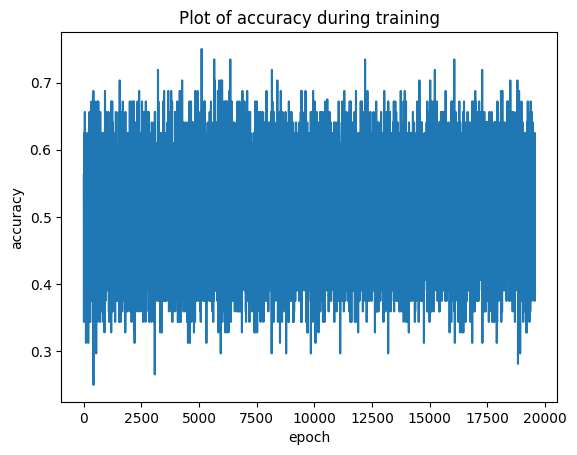

In [73]:
plt.plot(acc)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Plot of accuracy during training")
plt.show()

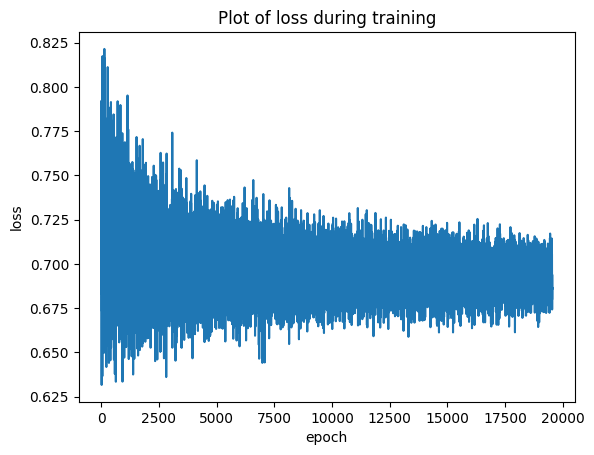

In [74]:
plt.plot(loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Plot of loss during training")
plt.show()

### Evaluation

Finally, evaluate the model on the test set.

In [75]:
def evaluate(model, features, labels, criterion):
    model.eval()
    with torch.no_grad():
        predictions = model(features)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
    return loss , acc

In [51]:
# Obtain the test features
test_features = vocab.process_and_convert_review_to_tensor(test_data["review"])
print(f"size of test features = {test_features.size()}")


# For the labels, encode positive as 1 and negative as 0
test_labels_pd = test_data["sentiment"].apply(lambda s: int(s == "positive"))
test_labels = torch.tensor(test_labels_pd.values.tolist()).unsqueeze(1).float()
print(f"size of test labels = {test_labels.size()}")

test_dataset = MovieReviewsDataset(test_features.to(device), test_labels.to(device))



size of test labels = torch.Size([25000, 1])


In [52]:
print(f"size of test features = {test_features.size()}")


size of test features = torch.Size([25000, 1397])


In [76]:
test_loss, test_acc = evaluate(
    model= lstm_model,
    features= test_features[:1000].to(device),
    labels = test_labels[:1000].to(device),
    criterion=criterion
)
test_loss, test_acc

(tensor(0.6940, device='cuda:0'), tensor(0.4870, device='cuda:0'))